In [1]:
import time
import collections
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sliding_window import sliding_window
from cluster_eval import greedy_relabel
from cluster_eval import brute_relabel
from cluster_eval import print_results
from cluster_eval import relabel_list
from keras import layers

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 24

# Hardcoded step of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_STEP = 12

In [2]:
def load_dataset(filename):

    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

def remove_class(X_train, y_train, X_test, y_test, class_n):
    uy_train = y_train[y_train != class_n]
    uX_train = X_train[y_train != class_n]
    uy_test = y_test[y_test != class_n]
    uX_test = X_test[y_test != class_n]
    
    classes = set(y_train)
    
    for x in range(class_n + 1, len(classes)):
        uy_train[uy_train == x] = x - 1
        uy_test[uy_test == x] = x - 1
        
    return uX_train, uy_train, uX_test, uy_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('oppChallenge_locomotion.data')

# def delete_features():
# RKN^, RKN_, BACK, HIP, R-SHOE, L-SHOE
# 53 Features

#features_delete = np.arange(6, 15)
#features_delete = np.concatenate([features_delete, np.arange(21, 36)])
#features_delete = np.concatenate([features_delete, np.arange(45, 81)])

# 60 Features
#features_delete = np.arange(0, 6)
#features_delete = np.concatenate([features_delete, np.arange(15, 21)])
#features_delete = np.concatenate([features_delete, np.arange(36, 45)])
#features_delete = np.concatenate([features_delete, np.arange(81, 113)])

# 9 Features (Phone)
#features_delete = np.arange(0, 36)
#features_delete = np.concatenate([features_delete, np.arange(45, 113)])

#features_delete = np.concatenate([features_delete, np.arange(6, 113)])

#X_train = np.delete(X_train, features_delete, 1)
#X_test = np.delete(X_test, features_delete, 1)

classes = ["Null", "Stand", "Walk" ,"Sit", "Lie"]

# 0 - null | 1 - stand | 2 - walk | 3 - sit | 4 - lie

X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 0) # remove null
classes.remove("Null")

# 0 - stand | 1 - walk | 2 - sit | 3 - lie

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 1) # remove walking
#classes.remove("Walk")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 3) # remove walking
#classes.remove("Lie")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 2) # remove walking
#classes.remove("Sit")

# 0 - stand | 1 - sit | 2 - lie

print(X_train.shape)
print(X_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
label_dict = dict(zip(unique, counts))
print(label_dict)

Loading data...
 ..from file oppChallenge_locomotion.data
 ..reading instances: train (557963, 113), test (118750, 113)
(465668, 113)
(94260, 113)
{0: 231751, 1: 130506, 2: 88883, 3: 14528}


In [3]:
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# Sensor data is segmented using a sliding window mechanism

X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

#X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
#X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

# Data is reshaped since the input of the network is a 4 dimension tensor
#X_train = X_train.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))
#X_test = X_test.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))

print(X_train.shape)
print(X_test.shape)

 ..after sliding window (testing): inputs (7854, 24, 113), targets (7854,)
(38804, 24, 113)
(7854, 24, 113)


In [4]:
# flatten sliding window

def flatten_sliding_window(X_data):
    return X_data.reshape(X_data.shape[0], (X_data.shape[1] * X_data.shape[2]))

In [5]:
import operator
import tensorflow as tf
from numpy.random import seed
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Sequential
from keras.callbacks import TensorBoard
from sklearn.cluster import KMeans

In [15]:
n = 0
seed(n)
tf.random.set_seed(n)

model = Sequential()
# encoder
model.add(Conv1D(128, 3, activation="relu", input_shape=(SLIDING_WINDOW_LENGTH, 113), padding="same"))
model.add(MaxPooling1D(2, padding="same"))
model.add(Conv1D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling1D(2, padding="same"))
#model.add(Conv1D(64, 3, activation="relu", padding="same"))
#model.add(MaxPooling1D(2, padding="same"))
# decoder
#model.add(Conv1D(64, 3, activation="relu", padding="same"))
#model.add(UpSampling1D(2)) 
model.add(Conv1D(64, 3, activation="relu", padding="same"))
model.add(UpSampling1D(2))
model.add(Conv1D(128, 3, activation="relu", padding="same"))
model.add(UpSampling1D(2))
model.add(Conv1D(113, 3, activation="sigmoid", padding="same"))
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 24, 128)           43520     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 12, 64)            24640     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 6, 64)             12352     
_________________________________________________________________
up_sampling1d_6 (UpSampling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 12, 128)          

In [16]:
model.fit(X_train, X_train, epochs=15, batch_size=100, validation_split=0.15)

Epoch 1/15
330/330 [==============================] - 7s 19ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 2/15
330/330 [==============================] - 6s 19ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3/15
330/330 [==============================] - 6s 19ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/15
330/330 [==============================] - 6s 18ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/15
330/330 [==============================] - 6s 18ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/15
330/330 [==============================] - 6s 18ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/15
330/330 [==============================] - 6s 18ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 8/15
330/330 [==============================] - 6s 18ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 9/15
330/330 [==============================] - 6s 18ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/15
330/330 [==============================] - 6s 18ms/step - loss: 9.9551e-04 - va

In [50]:
# save model
model.save('cae24_12_s8_d2')

INFO:tensorflow:Assets written to: cae24_12_s3_d2\assets


In [24]:
# load model
model = keras.models.load_model('cae24_12test')

In [17]:
# encoder becomes output
encoder = keras.Model(inputs=model.inputs, outputs=model.layers[3].output)

In [18]:
encoded_train = encoder.predict(X_train, verbose=0)
encoded_test = encoder.predict(X_test, verbose=0)
print(encoded_train.shape)
print(encoded_test.shape)

(38804, 6, 64)
(7854, 6, 64)


In [19]:
encoded_train = flatten_sliding_window(encoded_train)
encoded_test = flatten_sliding_window(encoded_test)
print(encoded_train.shape)
print(encoded_test.shape)

(38804, 384)
(7854, 384)


In [20]:
NUMBER_OF_CLUSTERS = 11

start = time.time()

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(encoded_train).predict(encoded_test)

end = time.time()

print("Time:")
print(end - start)

Time:
10.76755976676941


In [21]:
uy_pred = y_pred.copy()
clusters = list(set(y_pred))
clusters.sort()

#relabels = brute_relabel(uy_pred, y_test)
#relabels = greedy_relabel(uy_pred, y_test)
relabels = [0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 2]

uy_pred = relabel_list(uy_pred, clusters, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 2]

F1:
0.7847791224457888

Accuracy:
0.683982683982684

ARI:
0.4806471092946655


In [7]:
for n in range(0,10):
    seed(n)
    tf.random.set_seed(n)

    model = Sequential()
    # encoder
    model.add(Conv1D(128, 3, activation="relu", input_shape=(SLIDING_WINDOW_LENGTH, 113), padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(64, 3, activation="relu", padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    #model.add(Conv1D(64, 3, activation="relu", padding="same"))
    #model.add(MaxPooling1D(2, padding="same"))
    # decoder
    #model.add(Conv1D(64, 3, activation="relu", padding="same"))
    #model.add(UpSampling1D(2)) 
    model.add(Conv1D(64, 3, activation="relu", padding="same"))
    model.add(UpSampling1D(2))
    model.add(Conv1D(128, 3, activation="relu", padding="same"))
    model.add(UpSampling1D(2))
    model.add(Conv1D(113, 3, activation="sigmoid", padding="same"))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, X_train, epochs=1, batch_size=100, validation_split=0.15)
    
    encoder = keras.Model(inputs=model.inputs, outputs=model.layers[3].output)
    encoded_train = encoder.predict(X_train, verbose=0)
    encoded_test = encoder.predict(X_test, verbose=0)
    encoded_train = flatten_sliding_window(encoded_train)
    encoded_test = flatten_sliding_window(encoded_test)
    
    NUMBER_OF_CLUSTERS = 11

    start = time.time()
    y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(encoded_train).predict(encoded_test)
    end = time.time()

    print("Time:")
    print(end - start)
    print()
    
    uy_pred = y_pred.copy()
    clusters = list(set(y_pred))
    clusters.sort()

    relabels = greedy_relabel(uy_pred, y_test)

    uy_pred = relabel_list(uy_pred, clusters, relabels)
    print_results(uy_pred, y_test, relabels)

330/330 [==============================] - 10s 27ms/step - loss: 0.0057 - val_loss: 0.0028
Time:
11.832189321517944

Assigned Labels:
[3, 0, 1, 2, 1, 1, 0, 2, 0, 0, 3]

F1:
0.7090217371241742

Accuracy:
0.7100840336134454

ARI:
0.3923432630755432
330/330 [==============================] - 8s 22ms/step - loss: 0.0057 - val_loss: 0.0028
Time:
11.730547904968262

Assigned Labels:
[1, 2, 1, 3, 0, 0, 0, 3, 1, 2, 0]

F1:
0.7201330244662346

Accuracy:
0.7201426024955436

ARI:
0.41181562391161614
330/330 [==============================] - 8s 22ms/step - loss: 0.0054 - val_loss: 0.0027
Time:
12.178512811660767

Assigned Labels:
[3, 1, 2, 0, 0, 1, 0, 2, 1, 3, 1]

F1:
0.7290320068651118

Accuracy:
0.7298192004074358

ARI:
0.42506117805220467
330/330 [==============================] - 8s 22ms/step - loss: 0.0057 - val_loss: 0.0029
Time:
12.556668519973755

Assigned Labels:
[0, 0, 1, 2, 1, 0, 0, 1, 3, 0, 2]

F1:
0.7026348310870234

Accuracy:
0.7035905271199389

ARI:
0.3685434638432678
330/330 [====

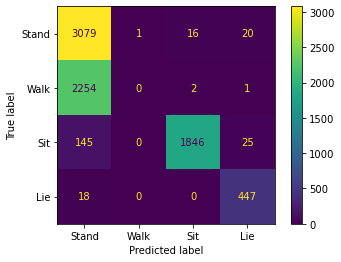

In [22]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

plt.savefig('confusion_matricies/c4_f113_km' + str(NUMBER_OF_CLUSTERS) + '+sw24_12+cae.png') # number of classes, features, method
plt.show()